In [1]:
!python export.py -o loop

Exported: /home/ck/code/loop/dev/00a_annotations.ipynb -> loop/annotations.py
Exported: /home/ck/code/loop/dev/00b_config.ipynb -> loop/config.py
Exported: /home/ck/code/loop/dev/00c_utils.ipynb -> loop/utils.py
Exported: /home/ck/code/loop/dev/00d_mixins.ipynb -> loop/mixins.py
Exported: /home/ck/code/loop/dev/01a_callbacks.ipynb -> loop/callbacks.py
Exported: /home/ck/code/loop/dev/01b_modules.ipynb -> loop/modules.py
Exported: /home/ck/code/loop/dev/02a_metrics.ipynb -> loop/metrics.py
Exported: /home/ck/code/loop/dev/02b_phase.ipynb -> loop/phase.py
Exported: /home/ck/code/loop/dev/02c_training.ipynb -> loop/training.py
Exported: /home/ck/code/loop/dev/03a_schedule.ipynb -> loop/schedule.py
Exported: /home/ck/code/loop/dev/03b_early_stopping.ipynb -> loop/early_stopping.py
Exported: /home/ck/code/loop/dev/99_testing.ipynb -> loop/testing.py
12 notebook(s) exported into folder: loop


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
#export
from pathlib import Path

import torch

from loop.callbacks import Callback, Order
from loop.utils import autoformat
from loop.training import raise_interruption

In [4]:
#export
class BestMetric(Callback):
    """A callback that memorizes the best value of metric.
    
    The class is intended to be a base class for other types of metric trackers that
    perform some action when metric stops to improve.
    """

    def __init__(self, phase: str='valid', metric: str='loss', better: 'callable'=min):
        self.phase = phase
        self.metric = metric
        self.better = better
        
    @property
    def formatted_best(self):
        return f'{self.phase}_{self.metric}={autoformat(self.best_value)}'
        
    def training_started(self, **kwargs):
        self.best_value = None
        
    def epoch_ended(self, phases, epoch, **kwargs):
        new_value = phases[self.phase].get_last_value(self.metric)
        if self.best_value is None:
            best_value = new_value
        else:
            best_value = self.better(self.best_value, new_value)
        self.best_value = best_value
        self.improved(epoch, best_value == new_value)
    
    def improved(self, epoch: int, was_improved: bool):
        """A method invoked at the end of each epoch reporting if the metric was improved."""

In [5]:
#export
class EarlyStopping(BestMetric):
    
    order = Order.Tracker(1)
    
    def __init__(self, patience: int=1, **kwargs):
        super().__init__(**kwargs)
        self.patience = patience
    
    def training_started(self, **kwargs):
        super().training_started(**kwargs)
        self.trials = 0
        
    def improved(self, epoch: int, was_improved: bool):
        if was_improved:
            self.trials = 0
            return
        else:
            self.trials += 1
            if self.trials >= self.patience:
                msg = f'Early stopping at epoch {epoch} with {self.formatted_best}\n'
                raise_interruption(msg)

In [6]:
#export
class ModelSaver(BestMetric):
    
    order = Order.Tracker(2)
    
    def __init__(self, mode: str='every', root: Path=Path.cwd(), 
                 prefix: str='model', **kwargs):
        super().__init__(**kwargs)
        assert mode in {'every', 'best'}
        self.mode = mode
        self.root = Path(root)
        self.prefix = prefix
        
    def training_started(self, **kwargs):
        super().training_started(**kwargs)
        if not self.root.exists():
            self.root.mkdir(parents=True)
        self.last_saved = None
        
    def improved(self, epoch: int, was_improved: bool):
        if self.mode == 'every' or was_improved:
            fname = f'{self.prefix}__{self.formatted_best}__epoch={epoch}.pth'
            path = self.root/fname
            torch.save(self.group.model.state_dict(), path)
            self.last_saved = path
            
    def load_last_saved_state(self, model=None):
        if self.last_saved is None:
            raise ValueError('nothing was saved during training')
        model = model or self.group.model
        if model is None:
            raise ValueError('no model provided to restore the saved state')
        model.load_state_dict(torch.load(self.last_saved))

Epoch:    1 | train_loss=0.1593, train_acc=0.9207, valid_loss=0.1340, valid_acc=0.9529
Epoch:    2 | train_loss=0.1205, train_acc=0.9630, valid_loss=0.1076, valid_acc=0.9647
Epoch:    3 | train_loss=0.0862, train_acc=0.9740, valid_loss=0.0841, valid_acc=0.9710
Early stopping at epoch 4 with valid_acc=0.9710
Validation accuracy: 97.10%


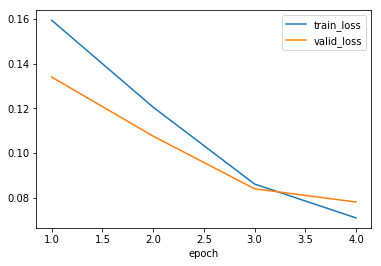

In [7]:
import numpy as np
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader

from loop.callbacks import Average
from loop.modules import fc_network
from loop.metrics import accuracy
from loop.training import Loop
from loop.testing import get_mnist
from loop.utils import from_torch

cbs = [Average(accuracy, alias='acc'), 
       EarlyStopping(metric='acc', patience=1, better=max),
       ModelSaver(mode='best', metric='acc', root=Path.home()/'models', better=max)]

trn_ds, val_ds = get_mnist(flat=True)
loop = Loop(fc_network(784, [100, 10]), cbs=cbs, loss_fn=cross_entropy)
loop.fit_datasets(trn_ds, val_ds, epochs=10000, batch_size=100)

loop.cb['history'].plot()
loop.cb['model_saver'].load_last_saved_state()
loop.model.eval()

result, actual = [], []
for x_val, y_val in DataLoader(val_ds, shuffle=False, batch_size=1024):
    y_hat = loop.model(x_val.to(loop.device))
    result += from_torch(y_hat).argmax(axis=1).tolist()
    actual += from_torch(y_val).tolist()

result = np.array(result)
actual = np.array(actual)
print(f'Validation accuracy: {(result == actual).mean():2.2%}')